![Py4Eng](img/logo.png)

# Image processing
## Yoav Ram

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy import signal, misc
from scipy import ndimage

from skimage import __version__
print("Scikit-image version", __version__)
import skimage.data
from skimage import measure
from skimage import filters
from skimage import morphology

sns.set(style='ticks', context='notebook', font_scale=1.5)
def display_image(image):
    plt.imshow(image, cmap='gray')
    plt.xticks([])
    plt.yticks([])

Scikit-image version 0.13.1


if `import skimage.xxx` causes an import error, try:
```
conda install skimage pillow imageio
```

# Denoising

Here's a salt-and-pepper noisy image of a famous person:

In [2]:
%less ../data/noisy.bitmap

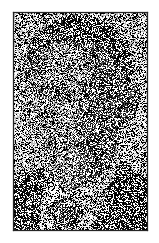

In [3]:
noisy = np.loadtxt(r'../data/noisy.bitmap', dtype=np.uint8)
display_image(noisy)

[![SciPy logo](http://space-kerala.org/freeelectron/wp-content/uploads/2013/11/scipyshiny_small.png)](http://scipy.org)

First let's try to denoise it with Scipy's median filter:

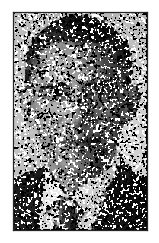

In [4]:
denoised = signal.medfilt2d(noisy)
display_image(denoised)

[![scikit-image](http://scikit-image.org/docs/stable/_static/img/logo.png)](http://scikit-image.org/)

Now using Scikit-image:

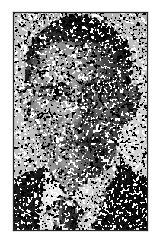

In [6]:
display_image(filters.median(noisy, morphology.square(3))) 

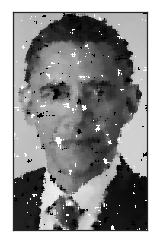

In [7]:
display_image(filters.median(noisy, morphology.square(7))) 

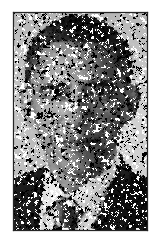

In [8]:
display_image(filters.median(noisy, morphology.disk(2))) 

## Bounded median

Now let's apply our own bounded median filter.

We want to replace the value of each outlier (noisy) pixel with the median of non-outlier neighbors. We'll write to functions, one to do it for white pixels and one for black pixels:

In [14]:
def local_bounded_median(neighbours, white_th, black_th):
    center = neighbours.size // 2
    pixel = neighbours[center]
    if pixel < black_th or pixel > white_th:
        mask = (black_th <= neighbours) & (neighbours <= white_th)
        if mask.any():
            return np.median(neighbours[mask])
    # either center was not extreme or all its neighbors are extreme
    return pixel

To apply these functions to each pixel we use SciPy's `generic_filter`, which accepts an image, a neighborhood definition, and a function to apply on the neighborhood to determine the pixel value.

In [15]:
from scipy.ndimage import generic_filter

In [16]:
def bounded_median(image, k=1, black_th=10, white_th=250):
    n = 2 * k + 1
    return generic_filter(image, local_bounded_median, 
                         size=(n, n), extra_arguments=(white_th, black_th))

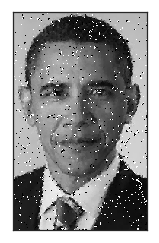

In [17]:
denoised = bounded_median(noisy)
display_image(denoised)

That's much better!

# Exercise - Dilation

Use `generic_filter` to apply a **dilation** filter on the following horse image: replace each pixel with the maximum of it's neighborhood.

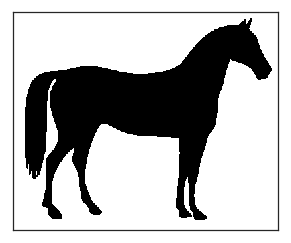

In [21]:
import skimage.data
horse = skimage.data.horse()
display_image(horse)

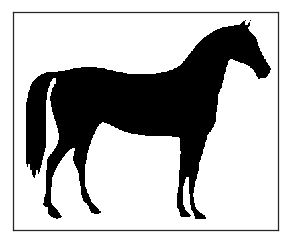

In [22]:
# Your code here
display_image(dilated)

We can also implement this with scikit-image:

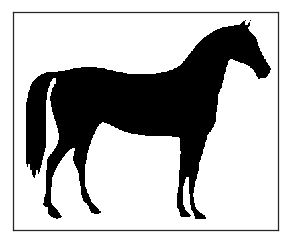

In [23]:
display_image(
    morphology.dilation(horse, morphology.square(3))
)

## Adding salt and pepper noise

Here's how the noise was added in the first place:

In [24]:
def salt_pepper(image, p=0.01):
    """Generates salt and pepper noise.
    
    Each pixel is "hit" independently with probability `p`. 
    If hit, a pixel has 1:1 chance of becoming white or black.
    """
    noisy = image.copy()
    rand = np.random.random(size=noisy.shape)
    mask_black = rand <= p/2
    noisy[mask_black] = 0
    mask_white = (p/2 < rand) & (rand <= p)
    noisy[mask_white] = 255
    return noisy

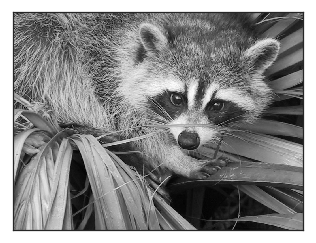

In [25]:
image = misc.face(gray=True)
display_image(image)

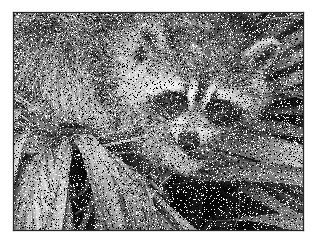

In [26]:
display_image(salt_pepper(image, p=0.2))

# Gaussian filter

Let's apply a gaussian filter for blurring. We'll use this image:

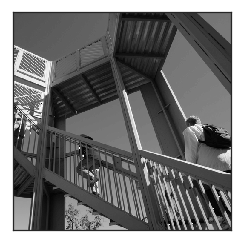

In [36]:
image = misc.ascent().astype(np.float64)
display_image(image)

## scipy.signal

We define a gaussian window using `scipy.signal.gaussian` of width 50 and $\sigma=10$:

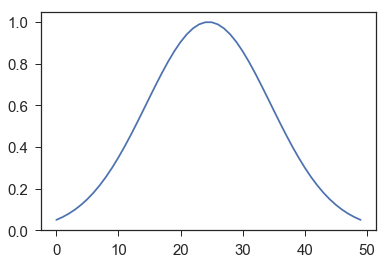

In [37]:
window = signal.gaussian(50, 10)
plt.plot(window);

Because the 2D gaussian filter can be described by the product of two 1D functions, we can use the function `scipy.signal.sepfir2d` to apply the filter:

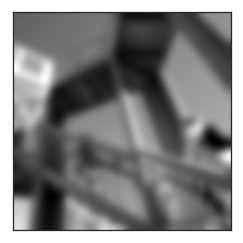

In [38]:
blurred = signal.sepfir2d(image, window, window)
display_image(blurred)

## scikit-image

Scikit-image has a function to apply a  gaussian filter, so let's just use it:

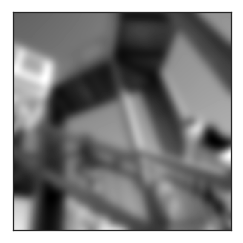

In [39]:
blurred = filters.gaussian(image, sigma=10)
display_image(blurred)

# Exercise - Edges

Use one of scikit-image's filters to find edge magnitude in the ascent image (last used image). Plot the result. 

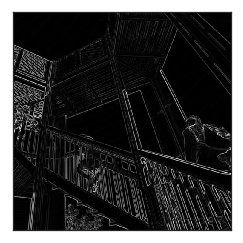

# Labeling

Now we will find objects in an image, and measure their sizes.

We'll work with the greek coins image from the scikit-image package.

Shape (303, 384)


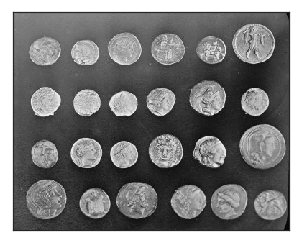

In [41]:
img = skimage.data.coins()
print("Shape", img.shape)
display_image(img)

First, we do a binary segmentation. Here I use a static threshold, but we could use something more clever from `skimage.filters` like `threshold_otsu` but in this case it works better to set the threshold to 120:

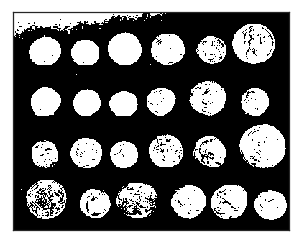

In [42]:
th = 120
bw = img > th
display_image(bw)

Next we use a dilation operator to (our own from before!) to clean up the coins.

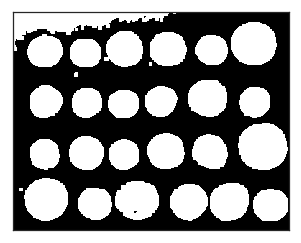

In [43]:
dilated = morphology.dilation(bw, morphology.square(5))
display_image(dilated)

Now we do the labeling using `skimage.measure.label` (you can also use`scipy.ndimage.label`):

In [44]:
labels = measure.label(dilated)
labels.shape

(303, 384)

The `labels` array specifies the label of each pixel, so we can plot it using a qualitative colormap to view the labels:

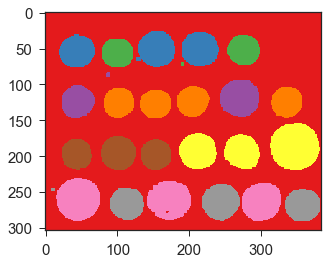

In [48]:
plt.imshow(labels, cmap=plt.cm.Set1);

We can use `skimage.measure.regionprops` to measure the properties of the labeled coins, such as their centroid, for adding a text label to the plot, and the area, to filter out small labels:

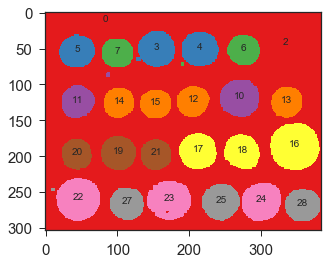

In [50]:
label_props = measure.regionprops(labels)
plt.imshow(labels, cmap=plt.cm.Set1)
for i, props in enumerate(label_props):
    if props.area < 500: 
        continue
    y, x = props.centroid
    plt.text(x, y, i, fontdict={'horizontalalignment':'center'})

Or we can plot a histogram of the areas:

/Users/yoavram/miniconda3/envs/Py4Eng/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


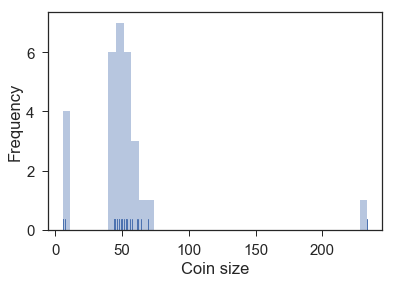

In [55]:
areas = [props.major_axis_length for props in label_props]
sns.distplot(areas, kde=False, rug=True)
plt.xlabel('Coin size')
plt.ylabel('Frequency');

# Exercise - labels

The [ImageIO](http://imageio.github.io) package provides functions to read and write images to and from array.
Use the module `imageio.imread` to read an image of a Lamium seed from [this url](https://github.com/yoavram/Sid/raw/master/Sid/images/image2.jpg). `imread` can read an image directly from a URL. Note that the returned array has 3 colors - hence the third dimension. Let's work only on the third channel of the first dimension, i.e. the red channel (from RGB).

![seed image](https://github.com/yoavram/Sid/raw/master/Sid/images/image2.jpg)

Then use the thresholding-segmentation-dilation-labeling-measuring process to measure the length of the seed, i.e. it's `major_axis_length`.

In [61]:
import imageio

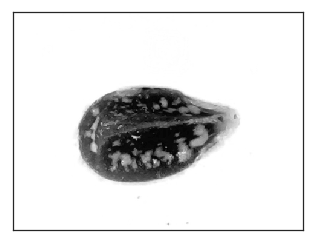

Perform the thresholding and segmentation:

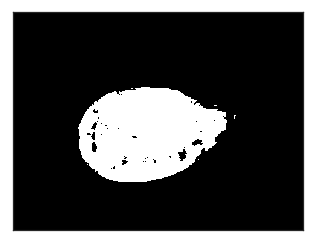

Perform the dilation (you can also use binary closing, see scikit-learn's `morphology` module).

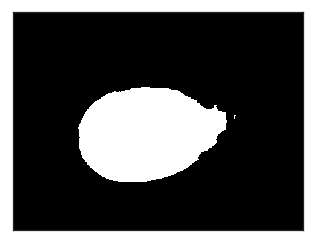

Now the labeling

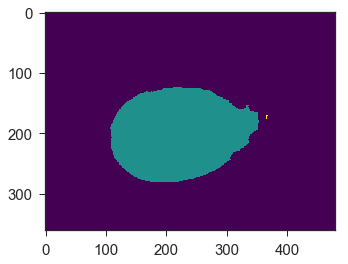

Finally the region properties measuring. I got two labels, one is the seed and one is a small particle to its right.

[240.79675874588676, 7.6689513231826325]

Solution is at [../solutions/label.py](../solutions/label.py).

# References

- [Scipy.Signal tutorial](https://scipy.github.io/devdocs/tutorial/signal.html)
- [Scipy.ndimage docs](https://docs.scipy.org/doc/scipy/reference/ndimage.html)
- [Scipy.ndimage tutorial](https://docs.scipy.org/doc/scipy-0.17.0/reference/tutorial/ndimage.html)
- [Scikit-Image docs](http://scikit-image.org/docs/0.11.x/)

## Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Python for Engineers_](https://github.com/yoavram/Py4Eng) course.

The notebook was written using [Python](http://python.org/) 3.6.1.
Dependencies listed in [environment.yml](../environment.yml), full versions in [environment_full.yml](../environment_full.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)